<a href="https://colab.research.google.com/github/morenourey/CHAT/blob/main/IBM_employee_attrition_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DS/DSC/2805/stuff/train.csv')

In [ ]:
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1058 non-null   int64 
 1   Attrition                 1058 non-null   int64 
 2   BusinessTravel            1058 non-null   object
 3   DailyRate                 1058 non-null   int64 
 4   Department                1058 non-null   object
 5   DistanceFromHome          1058 non-null   int64 
 6   Education                 1058 non-null   int64 
 7   EducationField            1058 non-null   object
 8   EmployeeCount             1058 non-null   int64 
 9   EmployeeNumber            1058 non-null   int64 
 10  EnvironmentSatisfaction   1058 non-null   int64 
 11  Gender                    1058 non-null   object
 12  HourlyRate                1058 non-null   int64 
 13  JobInvolvement            1058 non-null   int64 
 14  JobLevel                

In [ ]:
columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()

for columna in columnas_categoricas:
    print(df[columna].value_counts().to_string().replace('\n', '\n\t'))
    print("\n")


BusinessTravel
	Travel_Rarely        746
	Travel_Frequently    205
	Non-Travel           107


Department
	Research & Development    701
	Sales                     319
	Human Resources            38


EducationField
	Life Sciences       436
	Medical             330
	Marketing           122
	Technical Degree     96
	Other                59
	Human Resources      15


Gender
	Male      620
	Female    438


JobRole
	Sales Executive              232
	Research Scientist           214
	Laboratory Technician        188
	Manufacturing Director       107
	Healthcare Representative     88
	Manager                       79
	Research Director             62
	Sales Representative          58
	Human Resources               30


MaritalStatus
	Married     464
	Single      352
	Divorced    242


Over18
	Y    1058


OverTime
	No     751
	Yes    307




In [ ]:
columnas_numericas = df.select_dtypes(include=['int', 'float']).columns.tolist()

In [ ]:
corr = df[columnas_numericas].corr()

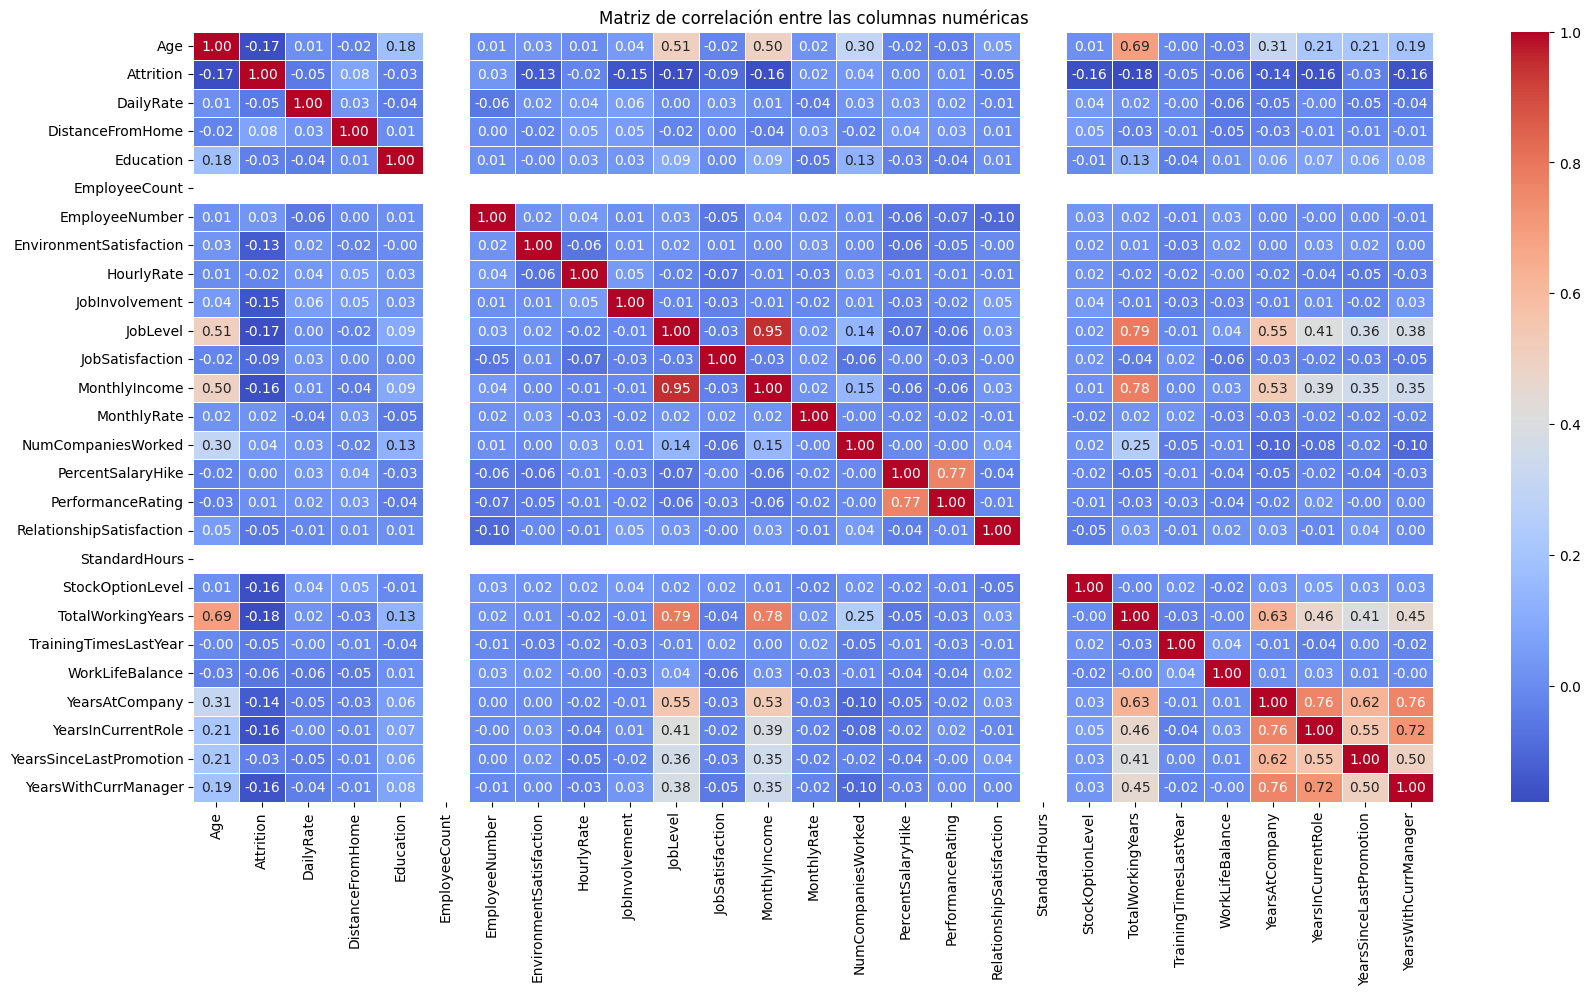

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación entre las columnas numéricas')
plt.show()

In [ ]:
attrition_correlations = corr['Attrition']
attrition_correlations = attrition_correlations.drop('Attrition')
top_5_correlations = attrition_correlations.abs().sort_values(ascending=False).head(5)

In [ ]:
top_5_correlations

TotalWorkingYears    0.177137
Age                  0.172067
JobLevel             0.169201
StockOptionLevel     0.164228
MonthlyIncome        0.163600
Name: Attrition, dtype: float64

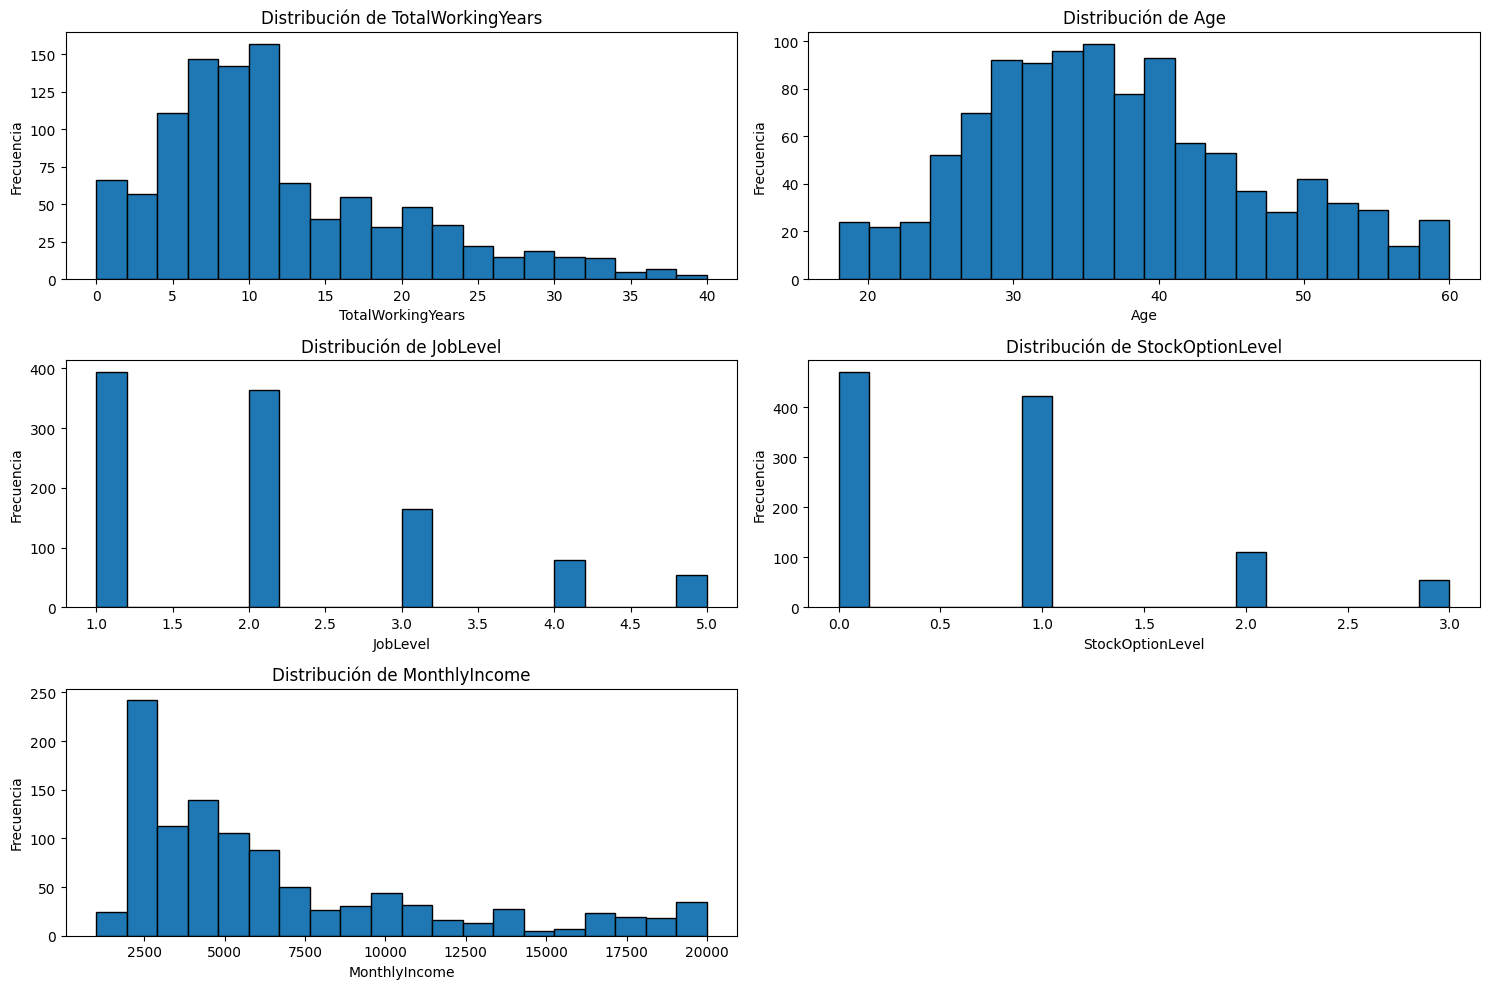

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

columns = ['TotalWorkingYears', 'Age', 'JobLevel', 'StockOptionLevel', 'MonthlyIncome']

for ax, column in zip(axes.flatten(), columns):
    ax.hist(df[column], bins=20, edgecolor='k')
    ax.set_title(f'Distribución de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Eliminar el último subplot vacío si es necesario
fig.delaxes(axes[2, 1])

# Ajustar el layout para que no se sobrepongan los títulos y etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### 1. Preprocessing

In [ ]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
def preprocess_input(df):
    df = df.copy()

    # Eliminamos columnas con valores únicos o con varianza muy baja.
    df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

    # Columnas binarias a 0 y 1 (no las codificamos en one-hot para evitar problemas de correlación)
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['OverTime'] = df['OverTime'].replace({'No': 0, 'Yes': 1})

    # Codificación ordinal
    df['BusinessTravel'] = df['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

    # Codificación one-hot
    for column in ['Department', 'EducationField', 'JobRole', 'MaritalStatus']:
        df = onehot_encode(df, column=column)

    # Dividir X e y
    y = df['Attrition']
    X = df.drop('Attrition', axis=1)

    # División de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=1)

    # Escalar los datos (no siempre necesario para clasificación, pero útil para consistencia)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test, scaler

# Ejemplo de uso:
# Suponiendo que df es tu DataFrame original
X_train, X_test, y_train, y_test, scaler = preprocess_input(df)



In [ ]:
X_train, X_test, y_train, y_test, scaler = preprocess_input(df)

In [ ]:
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
553,0.285824,-0.186605,-0.039058,-0.861349,-1.864619,1.175703,-1.160239,1.016023,-1.040808,-0.978181,...,-0.465035,-0.286104,-0.334966,-0.248152,2.028825,-0.534089,-0.245276,-0.541884,-0.904880,1.448329
676,-0.243257,-0.186605,0.775705,1.467369,-1.864619,1.175703,-1.160239,-0.727822,0.384686,-0.090655,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,-0.534089,-0.245276,-0.541884,1.105119,-0.690451
403,0.391640,-0.186605,-0.428089,-0.983913,0.089965,-0.648822,0.861892,-0.827470,1.810179,0.796870,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,1.872347,-0.245276,-0.541884,1.105119,-0.690451
766,1.343985,-0.186605,1.575787,-0.861349,1.067257,-0.648822,0.861892,-0.179756,0.384686,2.571922,...,-0.465035,-0.286104,-0.334966,4.029780,-0.492896,-0.534089,-0.245276,-0.541884,1.105119,-0.690451
567,-0.349073,-0.186605,-1.262426,-0.861349,0.089965,1.175703,0.861892,-0.279405,0.384686,-0.090655,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,1.872347,-0.245276,-0.541884,-0.904880,1.448329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.391640,1.710546,0.484543,-0.983913,0.089965,0.263440,-1.160239,0.019540,0.384686,-0.090655,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,1.872347,-0.245276,1.845415,-0.904880,-0.690451
847,-0.349073,1.710546,-0.369368,-0.983913,0.089965,1.175703,0.861892,1.564089,-1.040808,-0.090655,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,-0.534089,-0.245276,-0.541884,-0.904880,1.448329
715,-0.454889,1.710546,0.017217,-0.983913,1.067257,0.263440,-1.160239,0.916375,1.810179,-0.090655,...,-0.465035,-0.286104,-0.334966,-0.248152,-0.492896,-0.534089,-0.245276,-0.541884,1.105119,-0.690451
905,-0.878154,-0.186605,-0.308199,-0.983913,0.089965,1.175703,-1.160239,1.065847,-1.040808,1.684396,...,-0.465035,-0.286104,-0.334966,4.029780,-0.492896,-0.534089,-0.245276,1.845415,-0.904880,-0.690451


### 2. Training

In [ ]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                                 XGBoost": XGBClassifier(),
    "                                LightGBM": LGBMClassifier(),
    "                                CatBoost": CatBoostClassifier()
}

# Agrega modelos de ensemble
models.update({
    "Bagging": BaggingClassifier(),
    "Voting": VotingClassifier(estimators=list(models.items()))
})

# Entrena y evalúa cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                                 XGBoost trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 130, number of negative: 663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163934 -> initscore=-1.629241
[LightGBM] [Info] Start training from score -1.629241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 130, number of negative: 663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163934 -> initscore=-1.629241
[LightGBM] [Info] Start training from score -1.629241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

### 3. Results

In [ ]:
best_model = None
best_accuracy = 0.0

for name, model in models.items():
    accuracy = model.score(X_test, y_test)
    print(name + " trained. Accuracy: {:.2f}%".format(accuracy * 100))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print("Best model:", type(best_model))

                   Logistic Regression trained. Accuracy: 87.55%
                   K-Nearest Neighbors trained. Accuracy: 80.38%
                         Decision Tree trained. Accuracy: 76.23%
Support Vector Machine (Linear Kernel) trained. Accuracy: 87.17%
   Support Vector Machine (RBF Kernel) trained. Accuracy: 83.40%
                        Neural Network trained. Accuracy: 86.79%
                         Random Forest trained. Accuracy: 82.64%
                     Gradient Boosting trained. Accuracy: 82.64%
                                 XGBoost trained. Accuracy: 82.64%
                                LightGBM trained. Accuracy: 81.89%
                                CatBoost trained. Accuracy: 83.02%
Bagging trained. Accuracy: 80.75%
Voting trained. Accuracy: 82.64%
Best model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [ ]:
#probamos quitando el ordinal encoder y eliminando columnas correlacionadas

### TEST

In [ ]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)

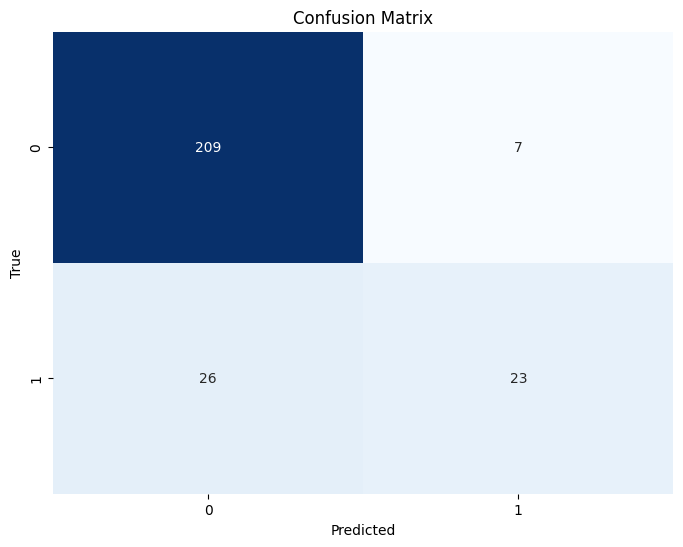

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       216
           1       0.77      0.47      0.58        49

    accuracy                           0.88       265
   macro avg       0.83      0.72      0.75       265
weighted avg       0.87      0.88      0.86       265



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Grafica la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Imprime el informe de clasificación
print("Classification Report:\n", classification_report(y_test, y_test_pred))



<Axes: xlabel='Attrition'>

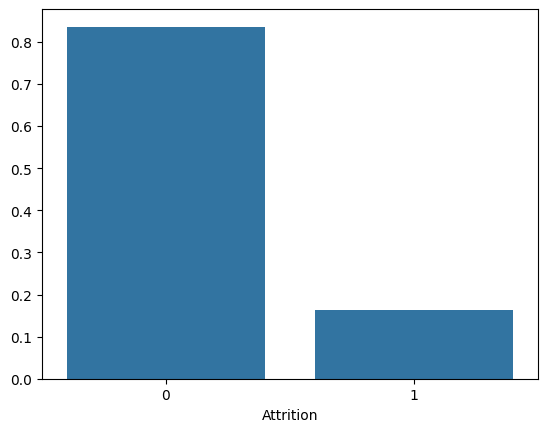

In [ ]:
class_counts = y_train.value_counts(normalize=True)
sns.barplot(x=class_counts.index, y=class_counts.values)

In [ ]:
class_counts

Attrition
0    0.836066
1    0.163934
Name: proportion, dtype: float64

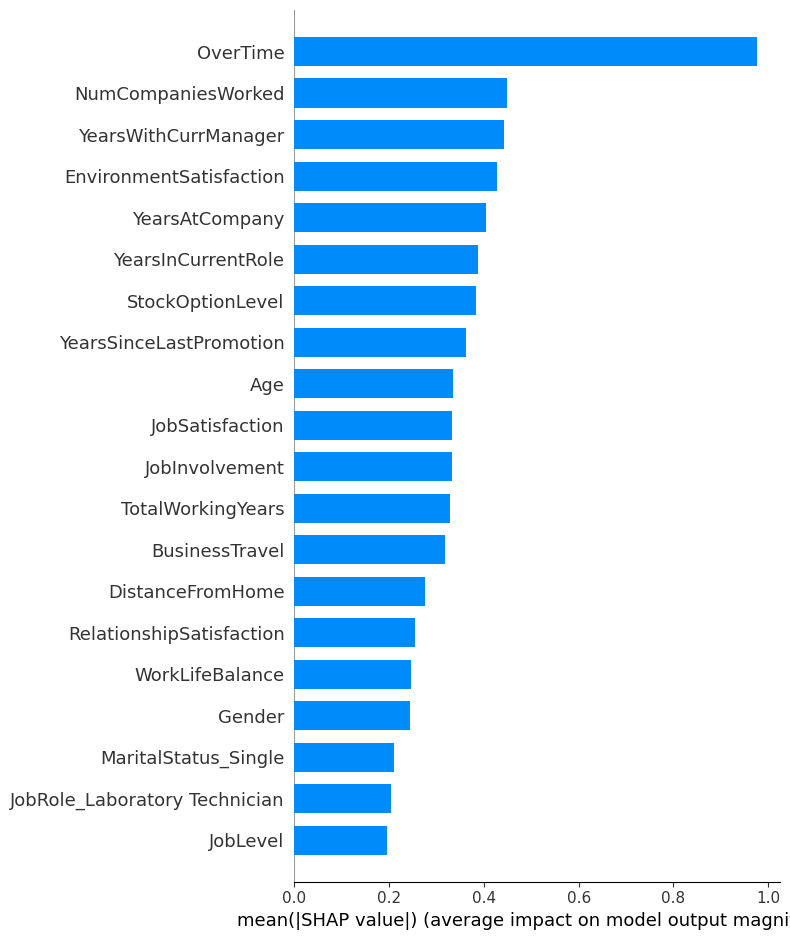

In [ ]:
!pip install shap
import shap

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


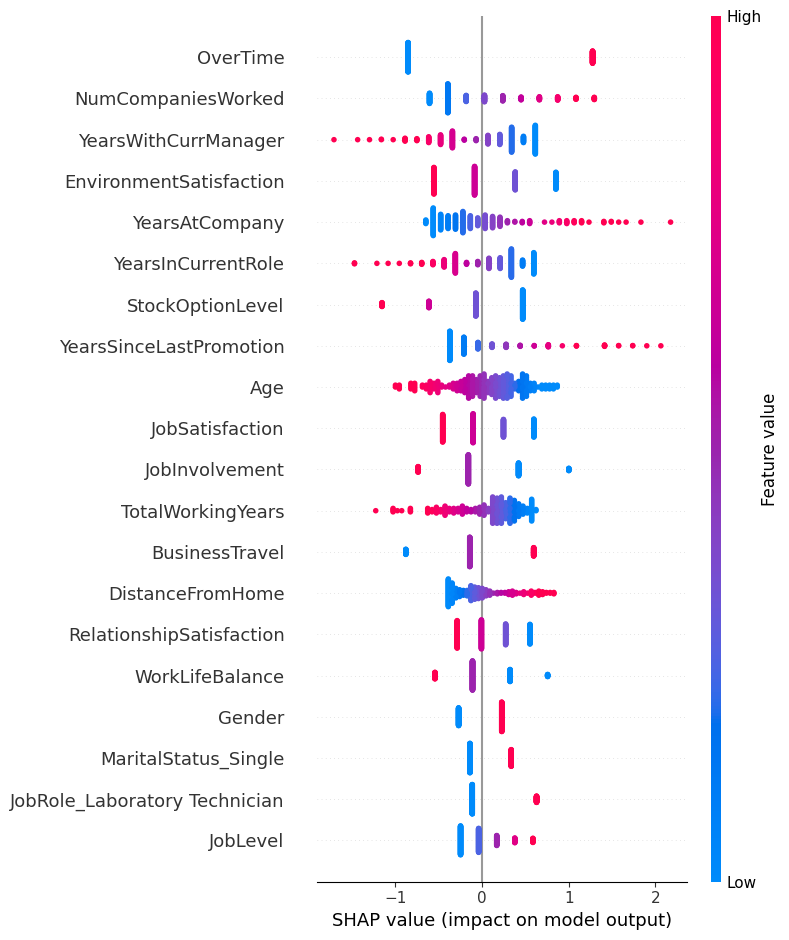

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/DS/DSC/2805/stuff/test.csv')

In [ ]:
def test_processor(df):
    df = df.copy()

    df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['OverTime'] = df['OverTime'].replace({'No': 0, 'Yes': 1})

    df['BusinessTravel'] = df['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

    for column in ['Department', 'EducationField', 'JobRole', 'MaritalStatus']:
        df = onehot_encode(df, column=column)

    df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

    return df



In [ ]:
test_processed = test_processor(test)

In [ ]:
predictions = model.predict(test_processed)

In [ ]:
test['Predictions'] = predictions

In [ ]:
test[test['Predictions']==1]

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Predictions
2,24,Travel_Frequently,381,Research & Development,9,3,Medical,1,1494,2,...,80,0,4,2,2,0,0,0,0,1
19,29,Travel_Rarely,224,Research & Development,1,4,Technical Degree,1,1522,1,...,80,0,11,2,1,9,7,0,7,1
79,22,Non-Travel,457,Research & Development,26,2,Other,1,1605,2,...,80,0,4,2,2,4,2,1,3,1
95,18,Travel_Frequently,544,Sales,3,2,Medical,1,1624,2,...,80,0,0,2,4,0,0,0,0,1
109,35,Travel_Rarely,763,Sales,15,2,Medical,1,1645,1,...,80,2,7,2,2,2,2,2,2,1
110,24,Travel_Frequently,567,Research & Development,2,1,Technical Degree,1,1646,1,...,80,0,6,2,3,6,3,1,3,1
113,40,Travel_Rarely,1329,Research & Development,7,3,Life Sciences,1,1649,1,...,80,0,10,3,1,4,2,0,3,1
143,23,Travel_Rarely,1320,Research & Development,8,1,Medical,1,1684,4,...,80,0,5,2,3,5,4,1,2,1
179,32,Travel_Rarely,964,Sales,1,2,Life Sciences,1,1734,1,...,80,0,10,2,3,0,0,0,0,1
191,29,Travel_Rarely,428,Sales,9,3,Marketing,1,1752,2,...,80,0,2,3,3,2,2,2,2,1


In [ ]:
1#jubilaciones como attrition?
#es buen modelo?

1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Entrenamiento del modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicción de probabilidades en datos de validación
probabilities = model.predict_proba(X_test)

# Define un umbral personalizado, cuanto mas bajo - más 1's acertaras pero a expensas de tener falsos positivos
threshold = 0.1  # por ejemplo

# Clasificación basada en el umbral ajustado
predictions = (probabilities[:, 1] >= threshold).astype(int)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78       216
           1       0.36      0.88      0.51        49

    accuracy                           0.69       265
   macro avg       0.66      0.77      0.65       265
weighted avg       0.85      0.69      0.73       265



In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[141,  75],
       [  6,  43]])

En resumen, el modelo parece tener un buen rendimiento en términos de sensibilidad para la clase 1 (los casos que se iban a ir), pero a expensas de una baja precisión y sensibilidad para la clase 0 (los casos que no se iban a ir). Esto sugiere que el modelo está clasificando la mayoría de los casos positivos correctamente, pero a costa de un alto número de falsos positivos para los casos negativos